In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
#Import pacific sheets and name change sheet

pacific_sheets = []
xls = pd.ExcelFile('Pacific 2021 zoo summary data.xlsx')
sheet_names = xls.sheet_names
print('number of sheets: ', len(sheet_names))
pacific_samples = sheet_names
for sheet_name in sheet_names:
    current_sheet = pd.read_excel(xls, sheet_name, header=None)
    pacific_sheets.append(current_sheet)


flowname_df = pd.read_excel('./FinnisData-20241007T133632Z-001/FinnisData/Method Paper/methodPaperZooNameChanges.xlsx', sheet_name='flowcamAdjustments')

#change taxa names in every sheet
replaced_sheets = []
replacement_dict = {}
for i, row in flowname_df.iterrows():
    replacement_dict[row['flowcamName']] =  row['newName']
    # print(replaced_df.loc[:50])
for i in range(len(pacific_sheets)):
    pacific_sheets[i] = pacific_sheets[i].replace(replacement_dict)

# cut each taxa's info into it's own dataframe within a dictionary, split between 2mm and 5mm ('small' and 'big')
dfdicts = []
for df in pacific_sheets:
    dfdict = {'big': {}, 'small': {}}
    taxa_size = 'small'
    for i, row in df.iterrows():
        if row[0] == '5mm taxa':
            taxa_size = 'big'
            print('hit the 5mm!')
        if row[0] == 'Class':
            # print(df.loc[i+1, 1])
            if df.loc[i+1, 1] > 0:
                # print(row[1])
                dfdict[taxa_size][row[1]] = {}
                dfdict[taxa_size][row[1]]['count'] = df.loc[i+1, 1]
                subdf = df.loc[i+4:i+22].copy().reset_index(drop=True)
                subdf.columns = subdf.iloc[0]
                subdf = subdf.drop(0).reset_index(drop=True)
                subdf = subdf.set_index('Summary Stats')
                dfdict[taxa_size][row[1]]['df'] = subdf
            # else:
            #     print('no counts of ', row[1])
    dfdicts.append(dfdict)

#FUNCTION FOR GETTING MEAN OF A STACK OF DFS

def mean_df(dfs, weights):
    # Compute weighted average
    weighted_sum = sum(df * weight for df, weight in zip(dfs, weights))
    total_weight = sum(weights)
    
    # Calculate the weighted average by dividing the weighted sum by the total weight
    df_weighted_average = weighted_sum / total_weight
    
    return df_weighted_average


#take the mean of stacked taxa dfs for each small sample (currently ignoring the 5mm data)
pacific_summary_dfs = []
for dfdict in dfdicts:
    taxa_keys = list(dfdict['small'].keys())
    # print(taxa_keys)
    dfs = []
    counts = []
    dict_means = []
    for taxa in taxa_keys:
        df = dfdict['small'][taxa]['df']
        means = df['Mean'].to_numpy()
        dict_means.append(means)
        dfs.append(dfdict['small'][taxa]['df'])
        counts.append(dfdict['small'][taxa]['count'])
    
    pacific_mean_df = mean_df(dfs, counts)
    pacific_mean_df = pacific_mean_df[['Mean']]
    pacific_summary_dfs.append(pacific_mean_df)

#organize 5mm organism counts by sample
pacific_big_counts_by_sample = []
for d, dfdict in enumerate(dfdicts):
    count = 0
    bigkeys = list(dfdict['big'].keys())
    for bigkey in bigkeys:
        count += dfdict['big'][bigkey]['count']
    pacific_big_counts_by_sample.append(count)


number of sheets:  10
hit the 5mm!
hit the 5mm!
hit the 5mm!
hit the 5mm!
hit the 5mm!
hit the 5mm!
hit the 5mm!
hit the 5mm!
hit the 5mm!
hit the 5mm!


In [3]:
pacific_summary_dfs[0]

,Mean
Summary Stats,
Area (ABD),175745.223751
Area (Filled),178298.762828
Biovolume (Cylinder),29971341.107872
Biovolume (P. Spheroid),105092837.706511
Biovolume (Sphere),73770116.618076
Diameter (ABD),444.408465
Diameter (ESD),698.224208
Diameter (FD),446.82896
Elongation,12.184917


In [4]:
#Relevant Pacific data, all lists of length 10:
#pacific_big_counts_by_sample
#pacific_samples
#pacific_summary_dfs

In [5]:
#NL 2020 Data

In [6]:
# import and format the NL 2020 sheets
nl_2020_sheets = []
xls = pd.ExcelFile('NL 2020 zoo summary data.xlsx')
sheet_names = xls.sheet_names
print('number of sheets: ', len(sheet_names))
nl_2020_samples = sheet_names
for sheet_name in sheet_names:
    current_sheet = pd.read_excel(xls, sheet_name, header=None)
    current_sheet = current_sheet.replace({'Count': 'count'})
    current_sheet = current_sheet.loc[2:].copy().reset_index(drop=True)
    current_sheet.columns = current_sheet.iloc[0]
    current_sheet = current_sheet.drop(0).reset_index(drop=True)
    # print(current_sheet.columns.values)
    current_sheet = current_sheet[current_sheet['count'] > 0].reset_index(drop=True)
    nl_2020_sheets.append(current_sheet)

number of sheets:  10


In [7]:
#filter for only the Mean columns
nl_2020_columns = list(nl_2020_sheets[0].columns.values)
nl_2020_filtered_columns = ['count']
for name in nl_2020_columns:
    if 'Mean' in name and 'hMean' not in name:
        nl_2020_filtered_columns.append(name)
for s, sheet in enumerate(nl_2020_sheets):
    nl_2020_sheets[s] = sheet[nl_2020_filtered_columns]


#create weighted average value df for each sheet
nl_2020_summary_dfs = []
for s, sheet in enumerate(nl_2020_sheets):
    mean_list = []
    counts = nl_2020_sheets[s]['count'].to_numpy()
    cols = list(sheet.columns.values)[1:]
    for col in cols:
        values = sheet[col].to_numpy()
        mean_list.append(np.average(values, weights=counts))
    new_df = pd.DataFrame({'Summary Stats': cols, 'Mean': mean_list})
    for i, row in new_df.iterrows():
        new_df.loc[i, 'Summary Stats'] = row['Summary Stats'][:-5]
    new_df = new_df.set_index('Summary Stats')
    nl_2020_summary_dfs.append(new_df)



In [8]:
nl_2020_summary_dfs[9]

,Mean
Summary Stats,
Area (ABD),2.340864e+05
Area (Filled),2.388471e+05
Biovolume (Cylinder),3.498904e+07
Biovolume (P. Spheroid),1.545965e+08
Biovolume (Sphere),9.383187e+07
Diameter (ABD),5.352753e+02
Diameter (ESD),8.471887e+02
Diameter (FD),5.406641e+02
Elongation,1.629020e+01


In [9]:
# import and format the NL 2021 sheets
nl_2021_sheets = []
xls = pd.ExcelFile('NL 2021 zoo summary data.xlsx')
sheet_names = xls.sheet_names
print('number of sheets: ', len(sheet_names))
nl_2021_samples = sheet_names
for sheet_name in sheet_names:
    current_sheet = pd.read_excel(xls, sheet_name, header=None)
    nl_2021_sheets.append(current_sheet)

number of sheets:  10


In [10]:
#change taxa names in every sheet
replaced_sheets = []
replacement_dict = {}
for i, row in flowname_df.iterrows():
    replacement_dict[row['flowcamName']] =  row['newName']
    # print(replaced_df.loc[:50])
for i in range(len(nl_2021_sheets)):
    nl_2021_sheets[i] = nl_2021_sheets[i].replace(replacement_dict)

In [11]:
#fix the last 2021 sheet which is formatted weirdly
nl_2021_sheets[9] = nl_2021_sheets[9].loc[6:].reset_index(drop=True)
cols = list(nl_2021_sheets[9].columns.values)
nl_2021_sheets[9] = nl_2021_sheets[9][cols[3:]]
nl_2021_sheets[9].columns = list(range(len(cols)-3))
nl_2021_sheets[9]

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Class,Zooplankton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Count,2217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Particles / ml,0.7336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Summary Stats,Mean,hMean,Min,Max,StdDev,% CV,D10,D25,D50,D75,D90,Total
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,Perimeter,8186.86,8065.64,6905.11,9269.61,975.51,11.92,6905.11,6905.11,7645.48,9269.61,9269.61,24560.6
117,Symmetry,0.4,0.37,0.26,0.51,0.1,26.02,0.26,0.26,0.34,0.51,0.51,1.2
118,Volume (ABD),525000000,482000000,334000000,654000000,138000000,26.29,334000000,334000000,461000000,654000000,654000000,2000000000
119,Volume (ESD),3440000000,2540000000,1400000000,5340000000,1610000000,46.84,1400000000,1400000000,2490000000,5340000000,5340000000,10000000000


In [12]:
# cut each taxa's info into it's own dataframe within a dictionary, split between 2mm and 5mm ('small' and 'big')
dfdicts = []
for d, df in enumerate(nl_2021_sheets):
    dfdict = {'big': {}, 'small': {}}
    taxa_size = 'small'
    # print(df.loc[0, 0])
    cols = list(df.columns.values)
    df = df[cols[:13]]
    for i, row in df.iterrows():
        if row[0] == '5mm Taxa:':
            taxa_size = 'big'
            # print('hit the 5mm!')
        if row[0] == 'Class':
            print(df.loc[i+1, 1])
            if df.loc[i+1, 1] > 0:
                # print(row[1])
                dfdict[taxa_size][row[1]] = {}
                dfdict[taxa_size][row[1]]['count'] = df.loc[i+1, 1]
                subdf = df.loc[i+4:i+22].copy().reset_index(drop=True)
                subdf.columns = subdf.iloc[0]
                subdf = subdf.drop(0).reset_index(drop=True)
                subdf = subdf.set_index('Summary Stats')
                dfdict[taxa_size][row[1]]['df'] = subdf
            # else:
            #     print('no counts of ', row[1])
    dfdicts.append(dfdict)

2717
3
2502
1
2307
1
2
1
2325
2
2620
1
1
2
2823
2554
2274
2
2376
2217
1
14
2
3


In [13]:

#take the mean of stacked taxa dfs for each small sample (currently ignoring the 5mm data)
nl_2021_summary_dfs = []
for dfdict in dfdicts:
    taxa_keys = list(dfdict['small'].keys())
    # print(taxa_keys)
    dfs = []
    counts = []
    dict_means = []
    for taxa in taxa_keys:
        df = dfdict['small'][taxa]['df']
        means = df['Mean'].to_numpy()
        dict_means.append(means)
        dfs.append(dfdict['small'][taxa]['df'])
        counts.append(dfdict['small'][taxa]['count'])
    print(len(counts))
    
    nl_2021_mean_df = mean_df(dfs, counts)
    nl_2021_mean_df = nl_2021_mean_df[['Mean']]
    nl_2021_summary_dfs.append(nl_2021_mean_df)

2
2
1
2
4
1
1
1
1
1


In [14]:
#organize 5mm organism counts by sample
nl_2021_big_counts_by_sample = []
for d, dfdict in enumerate(dfdicts):
    count = 0
    bigkeys = list(dfdict['big'].keys())
    for bigkey in bigkeys:
        count += dfdict['big'][bigkey]['count']
    nl_2021_big_counts_by_sample.append(count)


In [15]:
# Gulf data

In [16]:
# import and format the Gulf sheets
gulf_sheets = []
xls = pd.ExcelFile('Gulf 2020 zoo summary data.xlsx')
sheet_names = xls.sheet_names
print('number of sheets: ', len(sheet_names))
gulf_samples = sheet_names
for sheet_name in sheet_names:
    current_sheet = pd.read_excel(xls, sheet_name, header=None)
    gulf_sheets.append(current_sheet)

number of sheets:  10


In [17]:
# cut each taxa's info into it's own dataframe within a dictionary, split between 2mm and 5mm ('small' and 'big')
dfdicts = []
for d, df in enumerate(gulf_sheets):
    dfdict = {'big': {}, 'small': {}}
    taxa_size = 'small'
    for i, row in df.iterrows():
        if row[0] == '5mm Taxa:':
            taxa_size = 'big'
            # print('hit the 5mm!')
        if row[0] == 'Class':
            print(df.loc[i+1, 1])
            if df.loc[i+1, 1] > 0:
                # print(row[1])
                dfdict[taxa_size][row[1]] = {}
                dfdict[taxa_size][row[1]]['count'] = df.loc[i+1, 1]
                subdf = df.loc[i+4:i+22].copy().reset_index(drop=True)
                subdf.columns = subdf.iloc[0]
                subdf = subdf.drop(0).reset_index(drop=True)
                subdf = subdf.set_index('Summary Stats')
                dfdict[taxa_size][row[1]]['df'] = subdf
            # else:
            #     print('no counts of ', row[1])
    dfdicts.append(dfdict)

23513
23110
11672
18373
23195
14535
11440
8365
11742
17607


In [18]:
#take the mean of stacked taxa dfs for each small sample (currently ignoring the 5mm data)
gulf_summary_dfs = []
for dfdict in dfdicts:
    taxa_keys = list(dfdict['small'].keys())
    # print(taxa_keys)
    dfs = []
    counts = []
    dict_means = []
    for taxa in taxa_keys:
        df = dfdict['small'][taxa]['df']
        means = df['Mean'].to_numpy()
        dict_means.append(means)
        dfs.append(dfdict['small'][taxa]['df'])
        counts.append(dfdict['small'][taxa]['count'])
    print(len(counts))
    
    gulf_mean_df = mean_df(dfs, counts)
    gulf_mean_df = gulf_mean_df[['Mean']]
    gulf_summary_dfs.append(gulf_mean_df)

1
1
1
1
1
1
1
1
1
1


In [19]:
gulf_summary_dfs[0]

,Mean
Summary Stats,
Area (ABD),99994.24
Area (Filled),100000.0
Biovolume (Cylinder),12300000.0
Biovolume (P. Spheroid),47200000.0
Biovolume (Sphere),26400000.0
Diameter (ABD),343.48
Diameter (ESD),567.81
Diameter (FD),343.75
Elongation,11.28


In [20]:
#time to create one big df with all regionYears and image features
def create_creature_feature_df(dfs, sampleNames, regionYear):
    measure_array = []
    for d, df in enumerate(dfs):
        measures = list(df.index.values)
        sample_measures = list(df['Mean'])
        measure_array.append(sample_measures)
    measure_array = np.array(measure_array)
    df_dict = {}
    for m, measure in enumerate(measures):
        df_dict[measure] = measure_array[:, m]
    df_dict['sample'] = sampleNames
    creature_feature_df = pd.DataFrame(df_dict)
    creature_feature_df['regionYear'] = regionYear
    return creature_feature_df

creature_features_dfs = []
creature_feature_df = create_creature_feature_df(pacific_summary_dfs, pacific_samples, 'Pacific')
creature_features_dfs.append(creature_feature_df)


In [21]:
creature_feature_df = create_creature_feature_df(nl_2020_summary_dfs, nl_2020_samples, 'NL 2020')
creature_features_dfs.append(creature_feature_df)
creature_feature_df = create_creature_feature_df(nl_2021_summary_dfs, nl_2021_samples, 'NL 2021')
creature_features_dfs.append(creature_feature_df)
creature_feature_df = create_creature_feature_df(gulf_summary_dfs, gulf_samples, 'Gulf')
creature_features_dfs.append(creature_feature_df)

In [22]:
final_feature_df = pd.concat(creature_features_dfs).reset_index(drop=True)
# Get the last two columns
last_two_columns = final_feature_df.columns[-2:]

# Reorder the columns: last two columns come first, then the rest
new_column_order = list(last_two_columns) + list(final_feature_df.columns[:-2])

# Apply the new column order
final_feature_df = final_feature_df[new_column_order]
final_feature_df = final_feature_df.sort_values('sample').reset_index(drop=True)
measures = final_feature_df.columns.values
for measure in measures:
    print(measure)

sample
regionYear
Area (ABD)
Area (Filled)
Biovolume (Cylinder)
Biovolume (P. Spheroid)
Biovolume (Sphere)
Diameter (ABD)
Diameter (ESD)
Diameter (FD)
Elongation
Geodesic Aspect Ratio
Geodesic Length
Geodesic Thickness
Length
Perimeter
Symmetry
Volume (ABD)
Volume (ESD)
Width


In [23]:
#Go to import_ml_df.ipynb and run it to get ml_df_5000, or uncomment the next line and run it here.

#%run 'import_ml_df.ipynb'

%store -r ml_df_5000

#if you need the predictions using unlimited class sizes (max), load here.
#%store -r ml_df_max

ml_df = ml_df_5000

In [24]:
# these values come from the new Richness_BoxPlots file, calculated based on rarefaction.

%store -r ci_richness_dict
%store -r ci_shannon_dict
%store -r ci_pielou_dict
%store -r ci_samples

In [25]:
ci_samples

{'NL 2021': ['21_10_05_NL_S1_Z17_0752_250',
  '21_10_05_NL_S1_Z17_1406_250',
  '21_10_05_NL_S1_Z41_0854_250',
  '21_10_05_NL_S1_Z41_1327_250',
  '21_10_06_NL_S1_Z17_0802_250',
  '21_10_06_NL_S1_Z17_1442_250',
  '21_10_06_NL_S1_Z41_0839_250',
  '21_10_06_NL_S1_Z41_1412_250',
  '21_10_07_NL_S1_Z17_0830_250',
  '21_10_07_NL_S1_Z17_1459_250'],
 'Gulf': ['AMMP_Gulf_StPeters_1_20200903HT_250UM',
  'AMMP_Gulf_StPeters_1_20200903LT_250UM',
  'AMMP_Gulf_StPeters_1_20200904HT_250UM',
  'AMMP_Gulf_StPeters_2B_20200903_250UM',
  'AMMP_Gulf_StPeters_2_20200903HT_250UM',
  'AMMP_Gulf_StPeters_2_20200904HT_250UM',
  'AMMP_Gulf_StPeters_3B_20200903_250UM',
  'AMMP_Gulf_StPeters_3_20200903HT_250UM',
  'AMMP_Gulf_StPeters_3_20200903LT_250UM',
  'AMMP_Gulf_StPeters_3_20200904HT_250UM'],
 'NL 2020': ['AMMP_NL_S01_33_20200916AM_250UM',
  'AMMP_NL_S01_33_20200916PM_250UM',
  'AMMP_NL_S01_41_20200916AM_250UM',
  'AMMP_NL_S01_41_20200916PM_250UM',
  'AMMP_NL_S01_51_20200915PM_250UM',
  'AMMP_NL_S01_51_2020091

In [26]:
ci_rf_richness = {}
ci_rf_shannon = {}
ci_rf_pielou = {}
for key, sampleList in ci_richness_dict.items():
    for s, richness in enumerate(sampleList):
        ci_rf_richness[ci_samples[key][s]] = richness
        ci_rf_shannon[ci_samples[key][s]] = ci_shannon_dict[key][s]
        ci_rf_pielou[ci_samples[key][s]] = ci_pielou_dict[key][s]
ci_rf_pielou

{'21_10_05_NL_S1_Z17_0752_250': 0.6422025299156996,
 '21_10_05_NL_S1_Z17_1406_250': 0.6514341322292915,
 '21_10_05_NL_S1_Z41_0854_250': 0.7008558182448403,
 '21_10_05_NL_S1_Z41_1327_250': 0.6793302143582671,
 '21_10_06_NL_S1_Z17_0802_250': 0.6640353097521056,
 '21_10_06_NL_S1_Z17_1442_250': 0.681212105272944,
 '21_10_06_NL_S1_Z41_0839_250': 0.6531681902882257,
 '21_10_06_NL_S1_Z41_1412_250': 0.724988754237755,
 '21_10_07_NL_S1_Z17_0830_250': 0.7210745766191551,
 '21_10_07_NL_S1_Z17_1459_250': 0.6937317076618547,
 'AMMP_Gulf_StPeters_1_20200903HT_250UM': 0.5626917648134272,
 'AMMP_Gulf_StPeters_1_20200903LT_250UM': 0.727738731349231,
 'AMMP_Gulf_StPeters_1_20200904HT_250UM': 0.5372378487063914,
 'AMMP_Gulf_StPeters_2B_20200903_250UM': 0.6310662541491581,
 'AMMP_Gulf_StPeters_2_20200903HT_250UM': 0.713694229562779,
 'AMMP_Gulf_StPeters_2_20200904HT_250UM': 0.6323464696414436,
 'AMMP_Gulf_StPeters_3B_20200903_250UM': 0.6438023908297058,
 'AMMP_Gulf_StPeters_3_20200903HT_250UM': 0.72098725

In [27]:
samples = ml_df['sample_id'].unique()
richness_dict = {}
for sample in samples:
    sampledf = ml_df[ml_df['sample_id'] == sample]
    richness = len(sampledf['object_newname'].unique())
    richness_dict[sample] = richness

In [28]:

#true_pos
#false_pos
#false_neg
def get_f1(df):
    hit_dict = {}
    for i, row in df.iterrows():
        actualName = row['object_newname']
        predictedName = row['predicted_newName']
        if actualName not in list(hit_dict.keys()):
            hit_dict[actualName] = {'weights': 0, 'true_pos': 0, 'false_pos': 0, 'false_neg': 0}
        if predictedName not in list(hit_dict.keys()):
            hit_dict[predictedName] = {'weights': 0, 'true_pos': 0, 'false_pos': 0, 'false_neg': 0}
        hit_dict[actualName]['weights'] += 1
        if actualName == predictedName:
            hit_dict[actualName]['true_pos'] += 1
        else:
            hit_dict[actualName]['false_neg'] += 1
            hit_dict[predictedName]['false_pos'] += 1
    f1_dict = {}
    f1s = []
    counts = []
    for taxa in hit_dict.keys():
        if hit_dict[taxa]['weights'] > 0:
            counts.append(hit_dict[taxa]['weights'])
            f1_dict[taxa] = {}
            true_pos = hit_dict[taxa]['true_pos']
            false_pos = hit_dict[taxa]['false_pos']
            false_neg = hit_dict[taxa]['false_neg']
            if true_pos + false_pos > 0:
                precision = true_pos/(true_pos + false_pos)
            else:
                precision = 0
            recall = true_pos/(true_pos + false_neg)
            f1_dict[taxa]['precision'] = precision
            f1_dict[taxa]['recall'] = recall
            if precision == 0 and recall == 0:
                print(taxa)
                f1_dict[taxa]['f1'] = 0
                f1s.append(0)
            else:
                f1 = 2 * ((precision * recall)/(precision + recall))
                f1_dict[taxa]['f1'] = f1
                f1s.append(f1)
    print(len(f1s))
    print(len(counts))
    average_f1 = np.average(f1s, weights=counts)
    return average_f1, f1_dict
samples = ml_df['sample_id'].unique()
mean_f1s = {}
for sample in samples:
    f1, f1_dict = get_f1(ml_df[ml_df['sample_id'] == sample])
    mean_f1s[sample] = f1
mean_f1s


Centropages spp.
Pseudocalanus spp.
Cirripedia (larvae)
Paracalanus spp.
19
19
Harpacticoida- epibenthic
Decapoda- non-brachyura (larvae)
15
15
Eurytemora spp.
Decapoda- brachyura (larvae)
Pseudocalanus spp.
24
24
Temora spp.
Obelia spp. (medusa)
Hydrozoa (medusa)
Decapoda- non-brachyura (larvae)
13
13
Temora spp.
13
13
Bryozoa (larvae)
12
12
Cirripedia (larvae)
Harpacticoida- epibenthic
8
8
9
9
Echinodermata (larvae)
18
18
Hydrozoa (medusa)
11
11
Echinodermata (larvae)
Tortanus spp.
Bryozoa (larvae)
22
22
Calanoida (ci-ciii)
Echinodermata (larvae)
Polychaeta (larvae)
Oithona spp.
Ascidiacea (larvae)
21
21
Echinodermata (larvae)
20
20
Centropages spp.
Copepoda (nauplii)
Echinodermata (larvae)
Gastropoda (larvae/Limacina)
Polychaeta (larvae)
Tortanus spp.
20
20
Echinodermata (larvae)
20
20
Echinodermata (larvae)
Centropages spp.
Polychaeta (larvae)
Copepoda (nauplii)
Ascidiacea (larvae)
20
20
Gastropoda (larvae/Limacina)
Echinodermata (larvae)
21
21
Oithona spp.
Echinodermata (larvae)
P

{'AMMP_Gulf_StPeters_1_20200903HT_250UM': 0.8265119507643078,
 'AMMP_Gulf_StPeters_1_20200903LT_250UM': 0.6725637039063157,
 'AMMP_Gulf_StPeters_1_20200904HT_250UM': 0.8712383878322197,
 'AMMP_Gulf_StPeters_2B_20200903_250UM': 0.7006937883053874,
 'AMMP_Gulf_StPeters_2_20200903HT_250UM': 0.5545063395030903,
 'AMMP_Gulf_StPeters_2_20200904HT_250UM': 0.6332318027888544,
 'AMMP_Gulf_StPeters_3B_20200903_250UM': 0.6593640134780338,
 'AMMP_Gulf_StPeters_3_20200903HT_250UM': 0.5658911994365659,
 'AMMP_Gulf_StPeters_3_20200903LT_250UM': 0.8219616083079048,
 'AMMP_Gulf_StPeters_3_20200904HT_250UM': 0.6192017119355003,
 'AMMP_PA_S04W01_20210609HT_250um': 0.7681981618873511,
 'AMMP_PA_S04W01_20210609LT_250um': 0.7434223815279379,
 'AMMP_PA_S04W01_20210610HT_250um': 0.7207790020974949,
 'AMMP_PA_S04W01_20210610LT_250um': 0.7269785316869314,
 'AMMP_PA_S04W15_20210609HT_250um': 0.7150861090552039,
 'AMMP_PA_S04W15_20210609LT_250um': 0.7446013713003771,
 'AMMP_PA_S04W15_20210610LT_250um': 0.72561111

In [29]:
all_taxa_abunds = {}
all_taxa = ml_df['object_newname'].unique()
for taxa in all_taxa:
    all_taxa_abunds[taxa] = []
    taxadf = ml_df[ml_df['object_newname'] == taxa].sort_values('sample_id')
    for sample in samples:
        sampledf = taxadf[taxadf['sample_id'] == sample]
        if len(sampledf) > 0:
            all_taxa_abunds[taxa].append(len(sampledf) / len(ml_df[ml_df['sample_id'] == sample]))
        else:
            all_taxa_abunds[taxa].append(0)



In [30]:
abund_df = pd.DataFrame(all_taxa_abunds, index=samples)
abund_df

,Oithona spp.,Gastropoda (larvae/Limacina),Bivalvia (larvae),Temora spp.,Podon/Pleopsis spp.,Acartia spp.,Harpacticoida- epibenthic,Pseudodiaptomus spp.,Hydrozoa (medusa),Polychaeta (larvae),...,Eurytemora spp.,Osteichthyes (larvae),Fritillaria spp.,Oikopleura spp.,Corycaeidae,Calycophorae (nectophore),Tortanus spp.,Calanus spp.,Chaetognatha,Microcalanus spp.
AMMP_Gulf_StPeters_1_20200903HT_250UM,0.169743,0.051469,0.593449,0.044450,0.005719,0.049129,0.003639,0.014297,0.030933,0.004159,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AMMP_Gulf_StPeters_1_20200903LT_250UM,0.001530,0.003672,0.000000,0.000612,0.220930,0.561200,0.000612,0.012852,0.000306,0.008262,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AMMP_Gulf_StPeters_1_20200904HT_250UM,0.159173,0.025217,0.619213,0.011341,0.000934,0.024950,0.003602,0.005203,0.054570,0.016144,...,0.000133,0.000133,0.000400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AMMP_Gulf_StPeters_2B_20200903_250UM,0.004836,0.000345,0.001382,0.000345,0.071503,0.765112,0.002418,0.062176,0.000345,0.005527,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AMMP_Gulf_StPeters_2_20200903HT_250UM,0.004142,0.003899,0.002924,0.001218,0.065302,0.722222,0.001949,0.047758,0.000000,0.001949,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AMMP_Gulf_StPeters_2_20200904HT_250UM,0.002633,0.002155,0.003591,0.000000,0.009816,0.762030,0.001436,0.018674,0.000000,0.001197,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AMMP_Gulf_StPeters_3B_20200903_250UM,0.000000,0.001505,0.000000,0.000000,0.119807,0.771222,0.001806,0.041541,0.000000,0.002408,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AMMP_Gulf_StPeters_3_20200903HT_250UM,0.000619,0.000929,0.000000,0.000000,0.212937,0.653049,0.002476,0.057567,0.000000,0.002786,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AMMP_Gulf_StPeters_3_20200903LT_250UM,0.187535,0.053979,0.277685,0.012243,0.011964,0.110740,0.006678,0.033111,0.038954,0.004452,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AMMP_Gulf_StPeters_3_20200904HT_250UM,0.000975,0.000650,0.000650,0.000000,0.103672,0.786480,0.001950,0.008450,0.000325,0.003575,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [31]:
for key in mean_f1s.keys():
    if 'Gulf' in key:
        print(key)

AMMP_Gulf_StPeters_1_20200903HT_250UM
AMMP_Gulf_StPeters_1_20200903LT_250UM
AMMP_Gulf_StPeters_1_20200904HT_250UM
AMMP_Gulf_StPeters_2B_20200903_250UM
AMMP_Gulf_StPeters_2_20200903HT_250UM
AMMP_Gulf_StPeters_2_20200904HT_250UM
AMMP_Gulf_StPeters_3B_20200903_250UM
AMMP_Gulf_StPeters_3_20200903HT_250UM
AMMP_Gulf_StPeters_3_20200903LT_250UM
AMMP_Gulf_StPeters_3_20200904HT_250UM


In [32]:
gulf_sample_replace_dict = {
'AMMP_Gulf_StPeters_1_20200903HT_250UM': 'AMMP_Gulf_StPeters_1_20200903HT',
'AMMP_Gulf_StPeters_1_20200903LT_250UM': 'AMMP_Gulf_StPeters_1_20200903LT',
'AMMP_Gulf_StPeters_1_20200904HT_250UM': 'AMMP_Gulf_StPeters_1_20200904HT',
'AMMP_Gulf_StPeters_2B_20200903_250UM': 'AMMP_Gulf_StPeters_2B_20200903_',
'AMMP_Gulf_StPeters_2_20200903HT_250UM': 'AMMP_Gulf_StPeters_2_20200903HT',
'AMMP_Gulf_StPeters_2_20200904HT_250UM': 'AMMP_Gulf_StPeters_2_20200904HT',
'AMMP_Gulf_StPeters_3B_20200903_250UM': 'AMMP_Gulf_StPeters_3B_20200903_',
'AMMP_Gulf_StPeters_3_20200903HT_250UM': 'AMMP_Gulf_StPeters_3_20200903HT',
'AMMP_Gulf_StPeters_3_20200903LT_250UM': 'AMMP_Gulf_StPeters_3_20200903LT',
'AMMP_Gulf_StPeters_3_20200904HT_250UM': 'AMMP_Gulf_StPeters_3_20200904HT',
}

mean_f1s = {gulf_sample_replace_dict.get(k, k): v for k, v in mean_f1s.items()}

In [39]:
final_feature_df = final_feature_df.sort_values('sample').reset_index(drop=True)

final_feature_df

,sample,regionYear,Area (ABD),Area (Filled),Biovolume (Cylinder),Biovolume (P. Spheroid),Biovolume (Sphere),Diameter (ABD),Diameter (ESD),Diameter (FD),...,Geodesic Thickness,Length,Perimeter,Symmetry,Volume (ABD),Volume (ESD),Width,Richness,Shannon H',Pielou J'
0,21_10_05_NL_S1_Z17_0752_250,NL 2021,218356.250000,220356.250000,3.514941e+07,1.485206e+08,8.773438e+07,505.348202,823.502838,508.285974,...,169.387662,1040.299268,3779.116379,0.369735,8.773438e+07,5.282213e+08,561.055390,20.995,1.955041,0.642203
1,21_10_05_NL_S1_Z17_1406_250,NL 2021,206126.648022,208125.848981,3.190639e+07,1.504994e+08,7.858210e+07,495.847883,821.788853,499.046604,...,167.415230,1033.686221,3770.441243,0.369912,7.858210e+07,5.506344e+08,567.945569,20.841,1.978192,0.651434
2,21_10_05_NL_S1_Z41_0854_250,NL 2021,214000.000000,217000.000000,3.670000e+07,1.460000e+08,8.570000e+07,500.720000,819.210000,503.630000,...,175.780000,1044.490000,3691.920000,0.380000,8.570000e+07,4.950000e+08,550.110000,20.890,2.129955,0.700856
3,21_10_05_NL_S1_Z41_1327_250,NL 2021,201444.348947,204441.770520,3.357434e+07,1.237967e+08,7.452901e+07,491.409373,788.837327,494.257138,...,173.847465,1001.556738,3558.939858,0.370138,7.452901e+07,3.902815e+08,533.334912,20.000,2.035091,0.679330
4,21_10_06_NL_S1_Z17_0802_250,NL 2021,226544.207317,229560.594512,4.241875e+07,1.768136e+08,9.928201e+07,515.459242,861.428396,518.579383,...,164.401898,1086.238007,4022.212774,0.350103,9.928201e+07,6.012611e+08,591.986132,21.759,2.045003,0.664035
5,21_10_06_NL_S1_Z17_1442_250,NL 2021,206000.000000,210000.000000,3.480000e+07,1.240000e+08,7.890000e+07,495.720000,780.910000,500.050000,...,175.240000,985.060000,3586.330000,0.380000,7.890000e+07,4.160000e+08,533.550000,22.955,2.134561,0.681212
6,21_10_06_NL_S1_Z41_0839_250,NL 2021,211000.000000,215000.000000,4.170000e+07,1.470000e+08,9.420000e+07,496.410000,792.650000,500.260000,...,178.260000,1004.350000,3633.290000,0.390000,9.420000e+07,4.430000e+08,540.060000,21.867,2.014884,0.653168
7,21_10_06_NL_S1_Z41_1412_250,NL 2021,213000.000000,216000.000000,3.640000e+07,1.250000e+08,8.650000e+07,501.350000,795.680000,504.300000,...,175.240000,1013.150000,3622.980000,0.370000,8.650000e+07,4.750000e+08,531.210000,19.999,2.171835,0.724989
8,21_10_07_NL_S1_Z17_0830_250,NL 2021,206000.000000,209000.000000,3.250000e+07,1.450000e+08,7.890000e+07,495.490000,813.650000,499.170000,...,165.430000,1017.020000,3790.870000,0.360000,7.890000e+07,4.910000e+08,567.050000,19.866,2.155113,0.721075
9,21_10_07_NL_S1_Z17_1459_250,NL 2021,190000.000000,195000.000000,3.350000e+07,1.060000e+08,6.820000e+07,478.590000,729.270000,483.770000,...,188.540000,916.310000,3316.290000,0.410000,6.820000e+07,3.350000e+08,504.140000,19.865,2.073359,0.693732


In [35]:
reversed_gulf_sample_replace_dict = {v: k for k, v in gulf_sample_replace_dict.items()}

In [40]:
final_feature_df.columns.values

array(['sample', 'regionYear', 'Area (ABD)', 'Area (Filled)',
       'Biovolume (Cylinder)', 'Biovolume (P. Spheroid)',
       'Biovolume (Sphere)', 'Diameter (ABD)', 'Diameter (ESD)',
       'Diameter (FD)', 'Elongation', 'Geodesic Aspect Ratio',
       'Geodesic Length', 'Geodesic Thickness', 'Length', 'Perimeter',
       'Symmetry', 'Volume (ABD)', 'Volume (ESD)', 'Width', 'Richness',
       "Shannon H'", "Pielou J'"], dtype=object)

In [38]:

for i, row in final_feature_df.iterrows():
    if 'Gulf' in row['sample']:
        final_feature_df.loc[i, 'Richness'] = ci_rf_richness[reversed_gulf_sample_replace_dict[row['sample']]]
        final_feature_df.loc[i, 'Shannon H\''] = ci_rf_shannon[reversed_gulf_sample_replace_dict[row['sample']]]
        final_feature_df.loc[i, 'Pielou J\''] = ci_rf_pielou[reversed_gulf_sample_replace_dict[row['sample']]]
    else:
        final_feature_df.loc[i, 'Richness'] = ci_rf_richness[row['sample']]
        final_feature_df.loc[i, 'Shannon H\''] = ci_rf_shannon[row['sample']]
        final_feature_df.loc[i, 'Pielou J\''] = ci_rf_pielou[row['sample']]
final_feature_df

,sample,regionYear,Area (ABD),Area (Filled),Biovolume (Cylinder),Biovolume (P. Spheroid),Biovolume (Sphere),Diameter (ABD),Diameter (ESD),Diameter (FD),...,Geodesic Thickness,Length,Perimeter,Symmetry,Volume (ABD),Volume (ESD),Width,Richness,Shannon H',Pielou J'
0,21_10_05_NL_S1_Z17_0752_250,NL 2021,218356.250000,220356.250000,3.514941e+07,1.485206e+08,8.773438e+07,505.348202,823.502838,508.285974,...,169.387662,1040.299268,3779.116379,0.369735,8.773438e+07,5.282213e+08,561.055390,20.995,1.955041,0.642203
1,21_10_05_NL_S1_Z17_1406_250,NL 2021,206126.648022,208125.848981,3.190639e+07,1.504994e+08,7.858210e+07,495.847883,821.788853,499.046604,...,167.415230,1033.686221,3770.441243,0.369912,7.858210e+07,5.506344e+08,567.945569,20.841,1.978192,0.651434
2,21_10_05_NL_S1_Z41_0854_250,NL 2021,214000.000000,217000.000000,3.670000e+07,1.460000e+08,8.570000e+07,500.720000,819.210000,503.630000,...,175.780000,1044.490000,3691.920000,0.380000,8.570000e+07,4.950000e+08,550.110000,20.890,2.129955,0.700856
3,21_10_05_NL_S1_Z41_1327_250,NL 2021,201444.348947,204441.770520,3.357434e+07,1.237967e+08,7.452901e+07,491.409373,788.837327,494.257138,...,173.847465,1001.556738,3558.939858,0.370138,7.452901e+07,3.902815e+08,533.334912,20.000,2.035091,0.679330
4,21_10_06_NL_S1_Z17_0802_250,NL 2021,226544.207317,229560.594512,4.241875e+07,1.768136e+08,9.928201e+07,515.459242,861.428396,518.579383,...,164.401898,1086.238007,4022.212774,0.350103,9.928201e+07,6.012611e+08,591.986132,21.759,2.045003,0.664035
5,21_10_06_NL_S1_Z17_1442_250,NL 2021,206000.000000,210000.000000,3.480000e+07,1.240000e+08,7.890000e+07,495.720000,780.910000,500.050000,...,175.240000,985.060000,3586.330000,0.380000,7.890000e+07,4.160000e+08,533.550000,22.955,2.134561,0.681212
6,21_10_06_NL_S1_Z41_0839_250,NL 2021,211000.000000,215000.000000,4.170000e+07,1.470000e+08,9.420000e+07,496.410000,792.650000,500.260000,...,178.260000,1004.350000,3633.290000,0.390000,9.420000e+07,4.430000e+08,540.060000,21.867,2.014884,0.653168
7,21_10_06_NL_S1_Z41_1412_250,NL 2021,213000.000000,216000.000000,3.640000e+07,1.250000e+08,8.650000e+07,501.350000,795.680000,504.300000,...,175.240000,1013.150000,3622.980000,0.370000,8.650000e+07,4.750000e+08,531.210000,19.999,2.171835,0.724989
8,21_10_07_NL_S1_Z17_0830_250,NL 2021,206000.000000,209000.000000,3.250000e+07,1.450000e+08,7.890000e+07,495.490000,813.650000,499.170000,...,165.430000,1017.020000,3790.870000,0.360000,7.890000e+07,4.910000e+08,567.050000,19.866,2.155113,0.721075
9,21_10_07_NL_S1_Z17_1459_250,NL 2021,190000.000000,195000.000000,3.350000e+07,1.060000e+08,6.820000e+07,478.590000,729.270000,483.770000,...,188.540000,916.310000,3316.290000,0.410000,6.820000e+07,3.350000e+08,504.140000,19.865,2.073359,0.693732


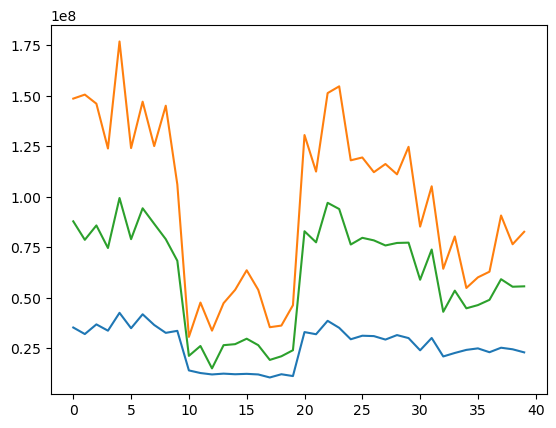

In [41]:
plt.plot(final_feature_df['Biovolume (Cylinder)'])
plt.plot(final_feature_df['Biovolume (P. Spheroid)'])
plt.plot(final_feature_df['Biovolume (Sphere)'])
plt.show()
plt.close()

In [42]:

normalized_f1s = {}
raw_f1s = {}
f1s = np.array(list(mean_f1s.values()))
norm_f1s = (f1s - np.min(f1s)) / (np.max(f1s) - np.min(f1s))
sample_names = list(mean_f1s.keys())
for s, sample in enumerate(sample_names):
    normalized_f1s[sample] = norm_f1s[s]
    raw_f1s[sample] = f1s[s]


def normalize(arr):
    arr = np.array(arr)
    norm_arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    return norm_arr

0.8768294206107173 0.8265119507643078
0.4528766981376136 0.6725637039063157
1.0 0.8712383878322197
0.5303431591580205 0.7006937883053874
0.12776262851838968 0.5545063395030903
0.3445619436722887 0.6332318027888544
0.41652652977204385 0.6593640134780338
0.1591149983068175 0.5658911994365659
0.8642983907877111 0.8219616083079048
0.30592496445867545 0.6192017119355003
0.716241105662822 0.7681981618873511
0.6480119458695445 0.7434223815279379
0.5856551308264802 0.7207790020974949
0.6027277997339646 0.7269785316869314
0.5699776706846068 0.7150861090552039
0.6512587247968458 0.7446013713003771
0.5989621292578348 0.7256111189134897
0.6616395265449451 0.7483709100847439
0.6982757329476866 0.7616744683549409
0.6495718851147497 0.7439888359915475
0.43014825606302953 0.664310416155775
0.20588853626420767 0.5828758861390856
0.2792173811754796 0.6095034946430694
0.41318383543247167 0.6581501943277347
0.30720011521588364 0.6196647523009606
0.3116111541359562 0.621266515121603
0.2780442695674514 0.60

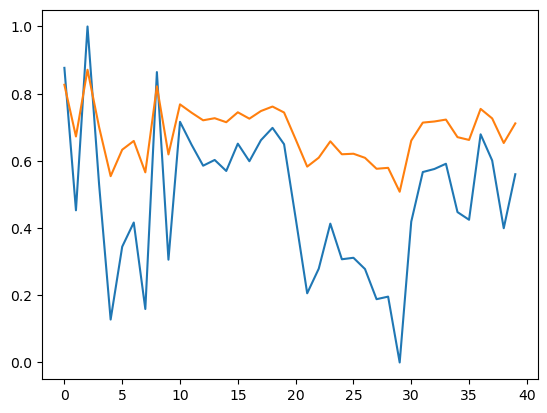

In [43]:
for key in normalized_f1s.keys():
    print(normalized_f1s[key], raw_f1s[key])
plt.plot(normalized_f1s.values())
plt.plot(raw_f1s.values())
plt.show()

In [44]:
final_feature_df.columns.values

array(['sample', 'regionYear', 'Area (ABD)', 'Area (Filled)',
       'Biovolume (Cylinder)', 'Biovolume (P. Spheroid)',
       'Biovolume (Sphere)', 'Diameter (ABD)', 'Diameter (ESD)',
       'Diameter (FD)', 'Elongation', 'Geodesic Aspect Ratio',
       'Geodesic Length', 'Geodesic Thickness', 'Length', 'Perimeter',
       'Symmetry', 'Volume (ABD)', 'Volume (ESD)', 'Width', 'Richness',
       "Shannon H'", "Pielou J'"], dtype=object)

In [45]:
included_measures = ['Symmetry', 'Richness', 'Shannon H\'', 'Pielou J\'', 'Biovolume (P. Spheroid)', 'Geodesic Thickness', 'Perimeter']
sampleRegionDict = {}
for i, row in final_feature_df.iterrows():
    sampleRegionDict[row['sample']] = row['regionYear']
final_feature_pca = final_feature_df.drop(columns=['regionYear'])
final_feature_pca = final_feature_pca.set_index('sample')
final_feature_pca = final_feature_pca[included_measures]
final_feature_pca

,Symmetry,Richness,Shannon H',Pielou J',Biovolume (P. Spheroid),Geodesic Thickness,Perimeter
sample,,,,,,,
21_10_05_NL_S1_Z17_0752_250,0.369735,20.995,1.955041,0.642203,1.485206e+08,169.387662,3779.116379
21_10_05_NL_S1_Z17_1406_250,0.369912,20.841,1.978192,0.651434,1.504994e+08,167.415230,3770.441243
21_10_05_NL_S1_Z41_0854_250,0.380000,20.890,2.129955,0.700856,1.460000e+08,175.780000,3691.920000
21_10_05_NL_S1_Z41_1327_250,0.370138,20.000,2.035091,0.679330,1.237967e+08,173.847465,3558.939858
21_10_06_NL_S1_Z17_0802_250,0.350103,21.759,2.045003,0.664035,1.768136e+08,164.401898,4022.212774
21_10_06_NL_S1_Z17_1442_250,0.380000,22.955,2.134561,0.681212,1.240000e+08,175.240000,3586.330000
21_10_06_NL_S1_Z41_0839_250,0.390000,21.867,2.014884,0.653168,1.470000e+08,178.260000,3633.290000
21_10_06_NL_S1_Z41_1412_250,0.370000,19.999,2.171835,0.724989,1.250000e+08,175.240000,3622.980000
21_10_07_NL_S1_Z17_0830_250,0.360000,19.866,2.155113,0.721075,1.450000e+08,165.430000,3790.870000


In [46]:
df = final_feature_pca
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
scaled_df = std_scaler.fit_transform(df)
features = df.columns.values
classes = df.index.values.tolist()
classes

['21_10_05_NL_S1_Z17_0752_250',
 '21_10_05_NL_S1_Z17_1406_250',
 '21_10_05_NL_S1_Z41_0854_250',
 '21_10_05_NL_S1_Z41_1327_250',
 '21_10_06_NL_S1_Z17_0802_250',
 '21_10_06_NL_S1_Z17_1442_250',
 '21_10_06_NL_S1_Z41_0839_250',
 '21_10_06_NL_S1_Z41_1412_250',
 '21_10_07_NL_S1_Z17_0830_250',
 '21_10_07_NL_S1_Z17_1459_250',
 'AMMP_Gulf_StPeters_1_20200903HT',
 'AMMP_Gulf_StPeters_1_20200903LT',
 'AMMP_Gulf_StPeters_1_20200904HT',
 'AMMP_Gulf_StPeters_2B_20200903_',
 'AMMP_Gulf_StPeters_2_20200903HT',
 'AMMP_Gulf_StPeters_2_20200904HT',
 'AMMP_Gulf_StPeters_3B_20200903_',
 'AMMP_Gulf_StPeters_3_20200903HT',
 'AMMP_Gulf_StPeters_3_20200903LT',
 'AMMP_Gulf_StPeters_3_20200904HT',
 'AMMP_NL_S01_33_20200916AM_250UM',
 'AMMP_NL_S01_33_20200916PM_250UM',
 'AMMP_NL_S01_41_20200916AM_250UM',
 'AMMP_NL_S01_41_20200916PM_250UM',
 'AMMP_NL_S01_51_20200915PM_250UM',
 'AMMP_NL_S01_51_20200916AM_250UM',
 'AMMP_NL_S01_51_20200916PM_250UM',
 'AMMP_NL_S01_77_20200915PM_250UM',
 'AMMP_NL_S01_77_20200916AM_250U

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
coords = pca.fit_transform(scaled_df)
coords

array([[-1.10125745e+00,  6.36738655e-01],
       [-1.11213603e+00,  3.91430543e-01],
       [-6.91555557e-01, -7.94805584e-01],
       [-6.79093871e-01, -5.10738555e-02],
       [-1.48188853e+00, -3.17169735e-01],
       [-7.65753907e-03, -6.45617429e-01],
       [-6.07748204e-01,  3.88747547e-01],
       [-5.34988108e-01, -1.27699598e+00],
       [-1.02061510e+00, -1.35430183e+00],
       [ 8.37738784e-03, -1.72949606e-03],
       [ 3.60444655e+00,  4.52735647e+00],
       [ 1.89815524e+00, -1.83758806e+00],
       [ 3.37319029e+00,  5.62267321e+00],
       [ 9.26550556e-01,  4.75380058e-01],
       [ 5.66232581e-01, -1.30819539e+00],
       [ 1.48182653e-01,  2.24402825e-01],
       [ 5.55844795e-01,  3.86151048e-01],
       [ 1.59347451e+00, -1.11690989e+00],
       [ 3.22486023e+00, -7.24446574e-01],
       [ 1.00616739e+00,  1.86025658e-01],
       [-2.17406690e+00,  8.23398329e-01],
       [-1.54816155e+00, -1.60970852e-02],
       [-2.35967571e+00,  8.79802426e-01],
       [-2.

In [48]:
explained_variance_ratio = pca.explained_variance_ratio_
print(explained_variance_ratio)
print(np.sum(explained_variance_ratio))

[0.42433354 0.305705  ]
0.7300385383758081


21_10_05_NL_S1_Z17_0752_250
21_10_05_NL_S1_Z17_1406_250
21_10_05_NL_S1_Z41_0854_250
21_10_05_NL_S1_Z41_1327_250
21_10_06_NL_S1_Z17_0802_250
21_10_06_NL_S1_Z17_1442_250
21_10_06_NL_S1_Z41_0839_250
21_10_06_NL_S1_Z41_1412_250
21_10_07_NL_S1_Z17_0830_250
21_10_07_NL_S1_Z17_1459_250
AMMP_Gulf_StPeters_1_20200903HT
AMMP_Gulf_StPeters_1_20200903LT
AMMP_Gulf_StPeters_1_20200904HT
AMMP_Gulf_StPeters_2B_20200903_
AMMP_Gulf_StPeters_2_20200903HT
AMMP_Gulf_StPeters_2_20200904HT
AMMP_Gulf_StPeters_3B_20200903_
AMMP_Gulf_StPeters_3_20200903HT
AMMP_Gulf_StPeters_3_20200903LT
AMMP_Gulf_StPeters_3_20200904HT
AMMP_NL_S01_33_20200916AM_250UM
AMMP_NL_S01_33_20200916PM_250UM
AMMP_NL_S01_41_20200916AM_250UM
AMMP_NL_S01_41_20200916PM_250UM
AMMP_NL_S01_51_20200915PM_250UM
AMMP_NL_S01_51_20200916AM_250UM
AMMP_NL_S01_51_20200916PM_250UM
AMMP_NL_S01_77_20200915PM_250UM
AMMP_NL_S01_77_20200916AM_250UM
AMMP_NL_S01_77_20200916PM_250UM
AMMP_PA_S04W01_20210609HT_250um
AMMP_PA_S04W01_20210609LT_250um
AMMP_PA_S04W01_2

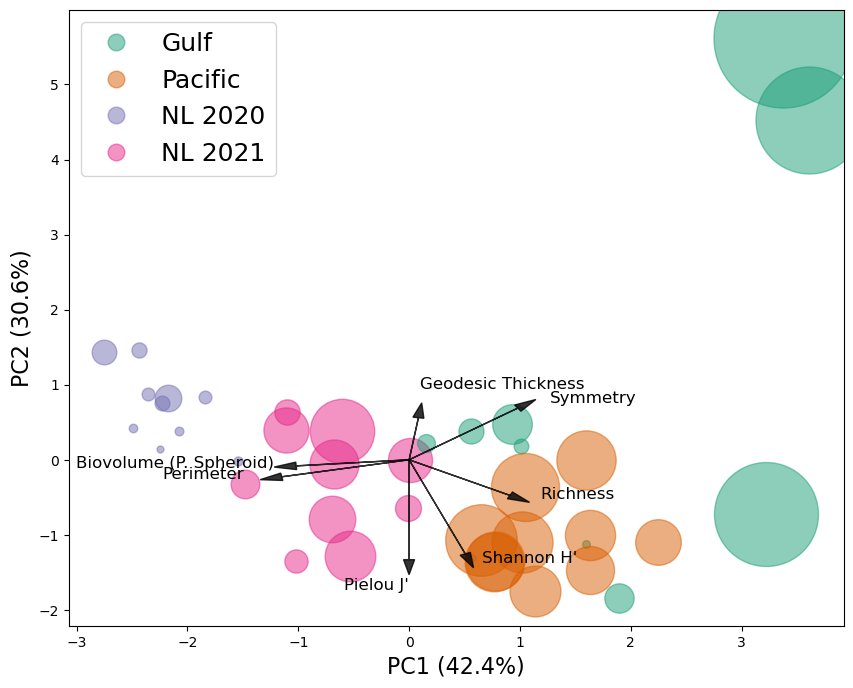

In [49]:
import matplotlib.lines as mlines
regionMarkers = {'Pacific': 'd', 'Gulf':'o', 'NL 2020': '^', 'NL 2021': 's'}
regionColors = {'Pacific': '#d95f02', 'Gulf':'#1b9e77', 'NL 2020': '#7570b3', 'NL 2021': '#e7298a'}
fig, axes = plt.subplots(figsize=(10, 8))
for c, coord in enumerate(coords):
    sampleName = classes[c]
    print(sampleName)

    plt.scatter(coord[0], coord[1], 
#                marker=regionMarkers[sampleRegionDict[sampleName]],
                marker='o',
                color=regionColors[sampleRegionDict[sampleName]], 
                label=sampleRegionDict[sampleName], 
                alpha=.5,
               s=(normalized_f1s[sampleName]*10)**4 + 25)
    # plt.text(coord[0] + .1, coord[1] + .1, classes[c])

component_coords = zip(pca.components_[0], pca.components_[1])
for c, component_coord in enumerate(component_coords):
    multiplier = 2.1
    plt.arrow(0, 0, component_coord[0] * multiplier, component_coord[1] * multiplier, color='black', alpha=0.8, head_width=0.1, head_length=0.2)
    if features[c] == 'Biovolume (P. Spheroid)' or features[c] == 'Pielou J\'':
        plt.text(component_coord[0] * multiplier * 1.2, component_coord[1] * multiplier * 1.3,
             features[c], color='black', fontsize=12,
            horizontalalignment='right' if component_coord[0] < 0 else 'left')
        continue
    if features[c] == 'Geodesic Thickness':
        plt.text(component_coord[0] * multiplier * 1.2, component_coord[1] * multiplier * 1.7,
             features[c], color='black', fontsize=12,
            horizontalalignment='right' if component_coord[0] < 0 else 'left')
        continue
    plt.text(component_coord[0] * multiplier * 1.3, component_coord[1] * multiplier * 1.1,
             features[c], color='black', fontsize=12,
            horizontalalignment='right' if component_coord[0] < 0 else 'left')
        
# Create custom legend handles with markers
marker1 = mlines.Line2D([], [], color=regionColors['Gulf'], marker='o', markersize=12, linestyle='', alpha=0.5, label='Gulf')  # Custom circle marker for Series 1
marker2 = mlines.Line2D([], [], color=regionColors['Pacific'], marker='o', markersize=12, linestyle='', alpha=0.5, label='Pacific')   # Custom square marker for Series 2
marker3 = mlines.Line2D([], [], color=regionColors['NL 2020'], marker='o', markersize=12, linestyle='', alpha=0.5, label='NL 2020')  # Custom circle marker for Series 1
marker4 = mlines.Line2D([], [], color=regionColors['NL 2021'], marker='o', markersize=12, linestyle='', alpha=0.5, label='NL 2021')   # Custom square marker for Series 2
# Add the custom legend to the plot
plt.legend(handles=[marker1, marker2, marker3, marker4], fontsize=18)
plt.xlabel(f"PC1 ({round(explained_variance_ratio[0] * 100, 1)}%)", fontsize=16)
plt.ylabel(f"PC2 ({round(explained_variance_ratio[1] * 100, 1)}%)", fontsize=16)
# plt.xlim([-2.8, 4])
plt.show()
plt.close()

In [52]:
f1_df = pd.DataFrame({'sample': list(normalized_f1s.keys()), 'norm f1': list(normalized_f1s.values()), 'f1': list(raw_f1s.values())})
f1_df = f1_df.sort_values('sample')
final_feature_df = final_feature_df.sort_values('sample')
final_feature_df

,sample,regionYear,Area (ABD),Area (Filled),Biovolume (Cylinder),Biovolume (P. Spheroid),Biovolume (Sphere),Diameter (ABD),Diameter (ESD),Diameter (FD),...,Geodesic Thickness,Length,Perimeter,Symmetry,Volume (ABD),Volume (ESD),Width,Richness,Shannon H',Pielou J'
0,21_10_05_NL_S1_Z17_0752_250,NL 2021,218356.250000,220356.250000,3.514941e+07,1.485206e+08,8.773438e+07,505.348202,823.502838,508.285974,...,169.387662,1040.299268,3779.116379,0.369735,8.773438e+07,5.282213e+08,561.055390,20.995,1.955041,0.642203
1,21_10_05_NL_S1_Z17_1406_250,NL 2021,206126.648022,208125.848981,3.190639e+07,1.504994e+08,7.858210e+07,495.847883,821.788853,499.046604,...,167.415230,1033.686221,3770.441243,0.369912,7.858210e+07,5.506344e+08,567.945569,20.841,1.978192,0.651434
2,21_10_05_NL_S1_Z41_0854_250,NL 2021,214000.000000,217000.000000,3.670000e+07,1.460000e+08,8.570000e+07,500.720000,819.210000,503.630000,...,175.780000,1044.490000,3691.920000,0.380000,8.570000e+07,4.950000e+08,550.110000,20.890,2.129955,0.700856
3,21_10_05_NL_S1_Z41_1327_250,NL 2021,201444.348947,204441.770520,3.357434e+07,1.237967e+08,7.452901e+07,491.409373,788.837327,494.257138,...,173.847465,1001.556738,3558.939858,0.370138,7.452901e+07,3.902815e+08,533.334912,20.000,2.035091,0.679330
4,21_10_06_NL_S1_Z17_0802_250,NL 2021,226544.207317,229560.594512,4.241875e+07,1.768136e+08,9.928201e+07,515.459242,861.428396,518.579383,...,164.401898,1086.238007,4022.212774,0.350103,9.928201e+07,6.012611e+08,591.986132,21.759,2.045003,0.664035
5,21_10_06_NL_S1_Z17_1442_250,NL 2021,206000.000000,210000.000000,3.480000e+07,1.240000e+08,7.890000e+07,495.720000,780.910000,500.050000,...,175.240000,985.060000,3586.330000,0.380000,7.890000e+07,4.160000e+08,533.550000,22.955,2.134561,0.681212
6,21_10_06_NL_S1_Z41_0839_250,NL 2021,211000.000000,215000.000000,4.170000e+07,1.470000e+08,9.420000e+07,496.410000,792.650000,500.260000,...,178.260000,1004.350000,3633.290000,0.390000,9.420000e+07,4.430000e+08,540.060000,21.867,2.014884,0.653168
7,21_10_06_NL_S1_Z41_1412_250,NL 2021,213000.000000,216000.000000,3.640000e+07,1.250000e+08,8.650000e+07,501.350000,795.680000,504.300000,...,175.240000,1013.150000,3622.980000,0.370000,8.650000e+07,4.750000e+08,531.210000,19.999,2.171835,0.724989
8,21_10_07_NL_S1_Z17_0830_250,NL 2021,206000.000000,209000.000000,3.250000e+07,1.450000e+08,7.890000e+07,495.490000,813.650000,499.170000,...,165.430000,1017.020000,3790.870000,0.360000,7.890000e+07,4.910000e+08,567.050000,19.866,2.155113,0.721075
9,21_10_07_NL_S1_Z17_1459_250,NL 2021,190000.000000,195000.000000,3.350000e+07,1.060000e+08,6.820000e+07,478.590000,729.270000,483.770000,...,188.540000,916.310000,3316.290000,0.410000,6.820000e+07,3.350000e+08,504.140000,19.865,2.073359,0.693732


In [53]:
f1s = f1_df['f1'].to_numpy()
final_feature_df['f1'] = f1s
final_feature_df['norm f1'] = f1_df['norm f1']
final_feature_df

,sample,regionYear,Area (ABD),Area (Filled),Biovolume (Cylinder),Biovolume (P. Spheroid),Biovolume (Sphere),Diameter (ABD),Diameter (ESD),Diameter (FD),...,Perimeter,Symmetry,Volume (ABD),Volume (ESD),Width,Richness,Shannon H',Pielou J',f1,norm f1
0,21_10_05_NL_S1_Z17_0752_250,NL 2021,218356.250000,220356.250000,3.514941e+07,1.485206e+08,8.773438e+07,505.348202,823.502838,508.285974,...,3779.116379,0.369735,8.773438e+07,5.282213e+08,561.055390,20.995,1.955041,0.642203,0.660283,0.876829
1,21_10_05_NL_S1_Z17_1406_250,NL 2021,206126.648022,208125.848981,3.190639e+07,1.504994e+08,7.858210e+07,495.847883,821.788853,499.046604,...,3770.441243,0.369912,7.858210e+07,5.506344e+08,567.945569,20.841,1.978192,0.651434,0.713931,0.452877
2,21_10_05_NL_S1_Z41_0854_250,NL 2021,214000.000000,217000.000000,3.670000e+07,1.460000e+08,8.570000e+07,500.720000,819.210000,503.630000,...,3691.920000,0.380000,8.570000e+07,4.950000e+08,550.110000,20.890,2.129955,0.700856,0.717213,1.000000
3,21_10_05_NL_S1_Z41_1327_250,NL 2021,201444.348947,204441.770520,3.357434e+07,1.237967e+08,7.452901e+07,491.409373,788.837327,494.257138,...,3558.939858,0.370138,7.452901e+07,3.902815e+08,533.334912,20.000,2.035091,0.679330,0.722884,0.530343
4,21_10_06_NL_S1_Z17_0802_250,NL 2021,226544.207317,229560.594512,4.241875e+07,1.768136e+08,9.928201e+07,515.459242,861.428396,518.579383,...,4022.212774,0.350103,9.928201e+07,6.012611e+08,591.986132,21.759,2.045003,0.664035,0.670633,0.127763
5,21_10_06_NL_S1_Z17_1442_250,NL 2021,206000.000000,210000.000000,3.480000e+07,1.240000e+08,7.890000e+07,495.720000,780.910000,500.050000,...,3586.330000,0.380000,7.890000e+07,4.160000e+08,533.550000,22.955,2.134561,0.681212,0.662334,0.344562
6,21_10_06_NL_S1_Z41_0839_250,NL 2021,211000.000000,215000.000000,4.170000e+07,1.470000e+08,9.420000e+07,496.410000,792.650000,500.260000,...,3633.290000,0.390000,9.420000e+07,4.430000e+08,540.060000,21.867,2.014884,0.653168,0.754685,0.416527
7,21_10_06_NL_S1_Z41_1412_250,NL 2021,213000.000000,216000.000000,3.640000e+07,1.250000e+08,8.650000e+07,501.350000,795.680000,504.300000,...,3622.980000,0.370000,8.650000e+07,4.750000e+08,531.210000,19.999,2.171835,0.724989,0.726384,0.159115
8,21_10_07_NL_S1_Z17_0830_250,NL 2021,206000.000000,209000.000000,3.250000e+07,1.450000e+08,7.890000e+07,495.490000,813.650000,499.170000,...,3790.870000,0.360000,7.890000e+07,4.910000e+08,567.050000,19.866,2.155113,0.721075,0.653185,0.864298
9,21_10_07_NL_S1_Z17_1459_250,NL 2021,190000.000000,195000.000000,3.350000e+07,1.060000e+08,6.820000e+07,478.590000,729.270000,483.770000,...,3316.290000,0.410000,6.820000e+07,3.350000e+08,504.140000,19.865,2.073359,0.693732,0.711566,0.305925


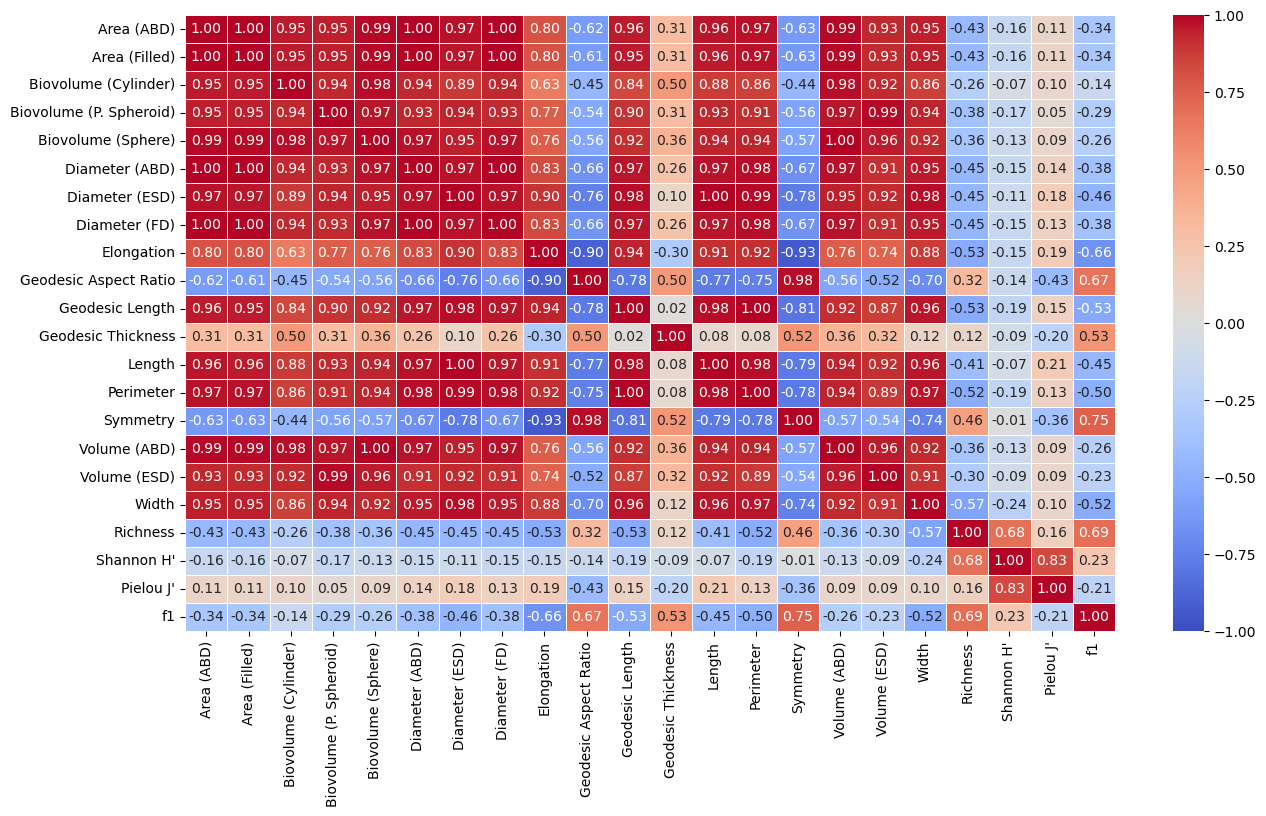

In [55]:
final_feature_values = final_feature_df.drop(columns=['sample', 'regionYear', 'norm f1'])
corr = final_feature_values.corr()
import seaborn as sns
plt.figure(figsize=(15, 8))  # Optional: Adjust size of the plot
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

# Show the plot
plt.show()
plt.close()

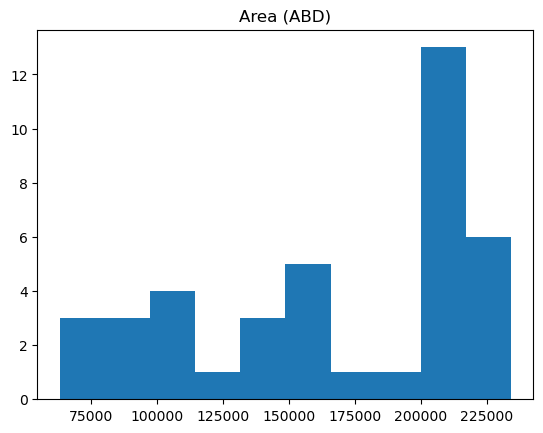

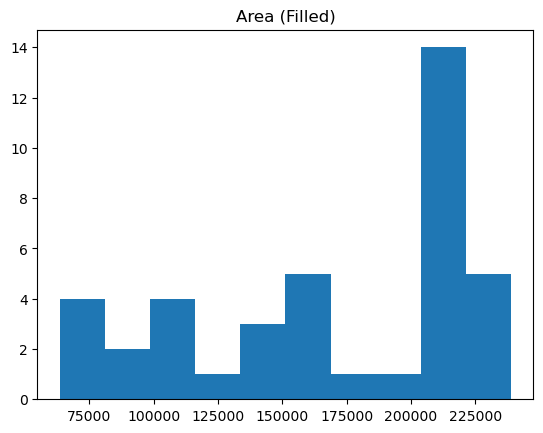

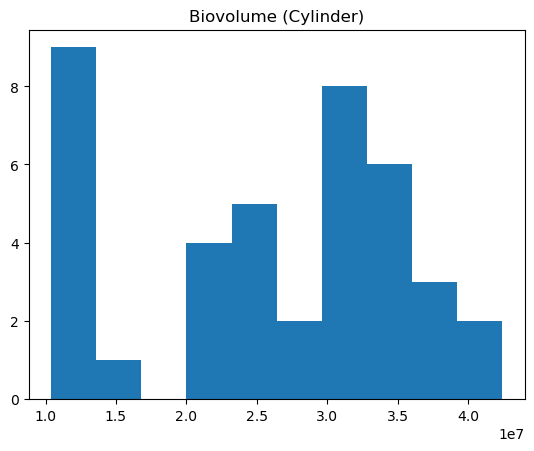

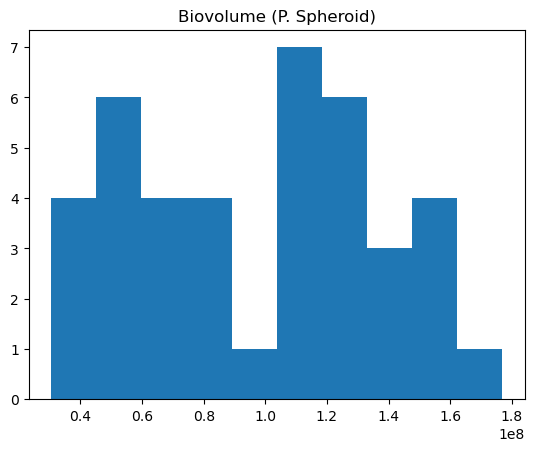

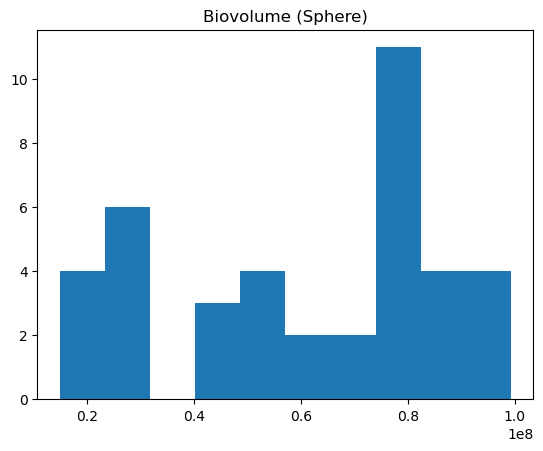

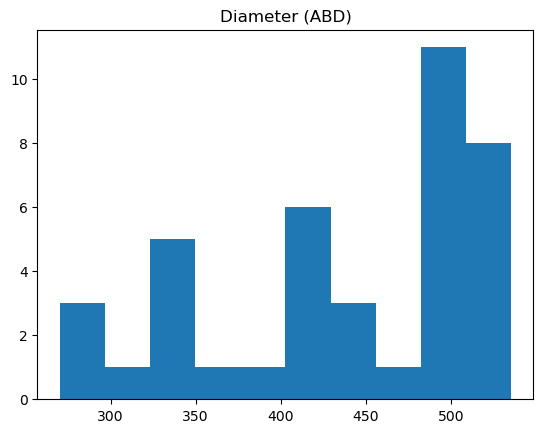

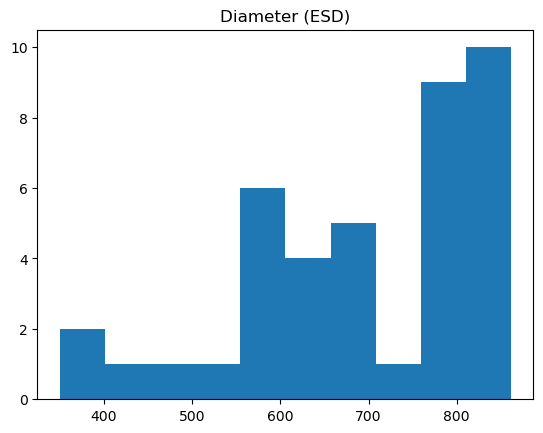

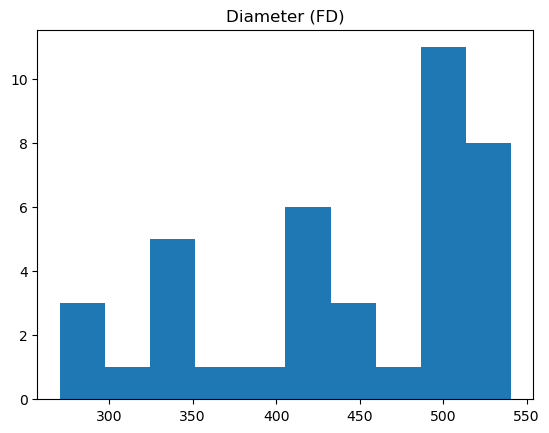

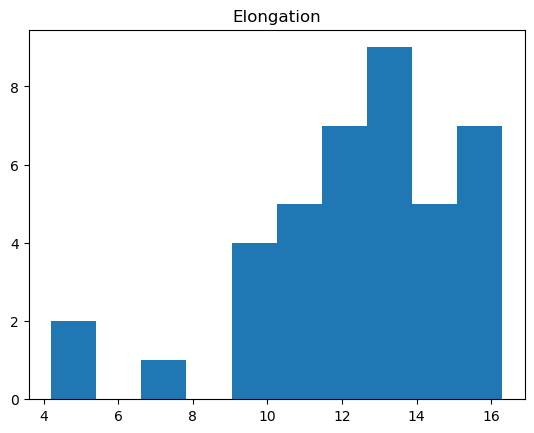

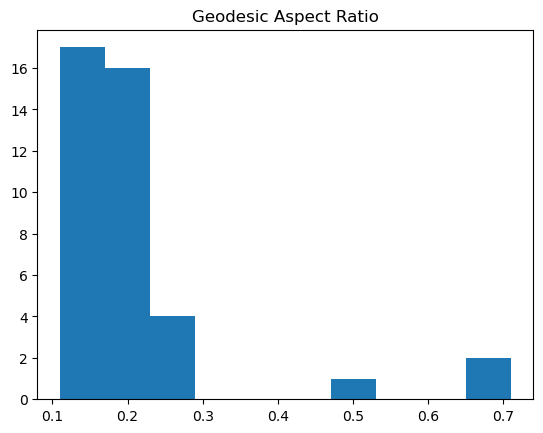

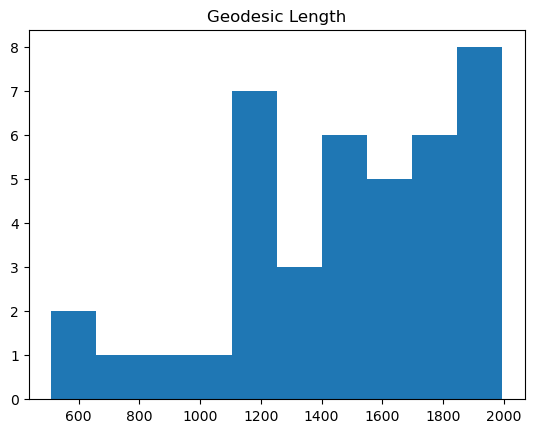

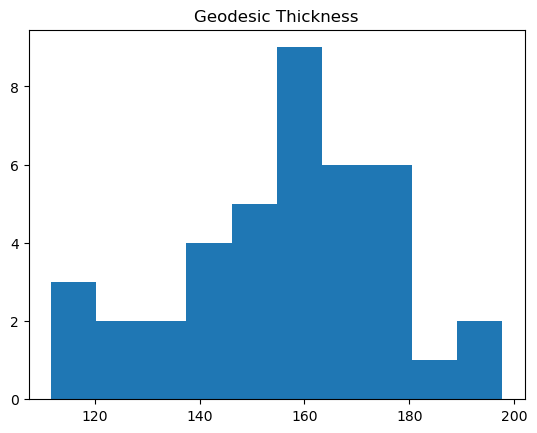

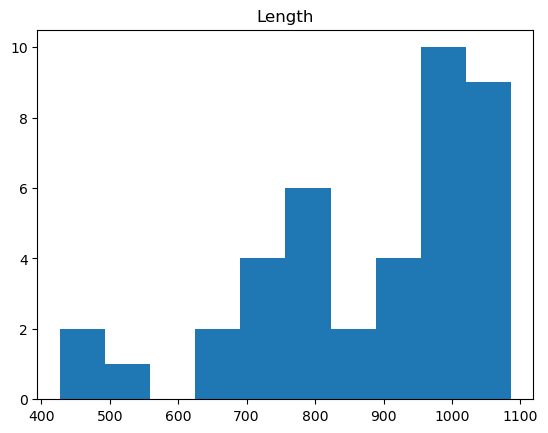

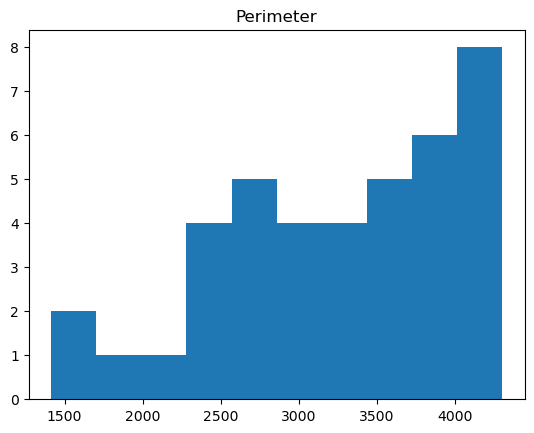

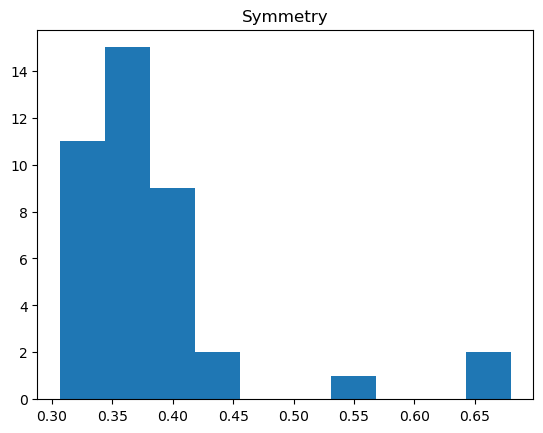

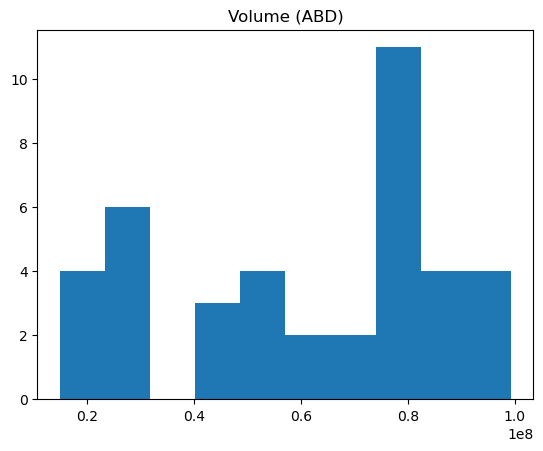

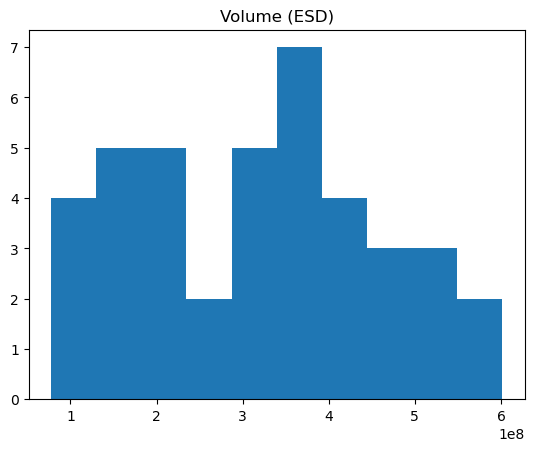

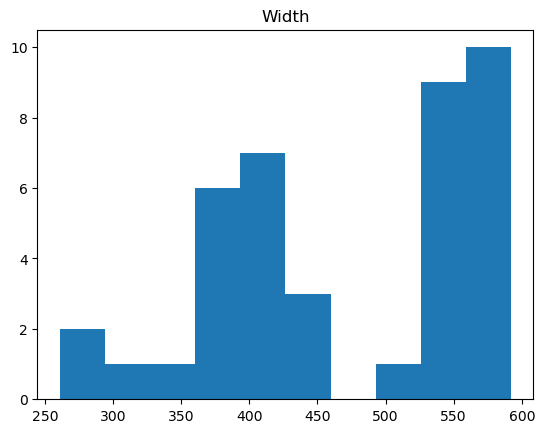

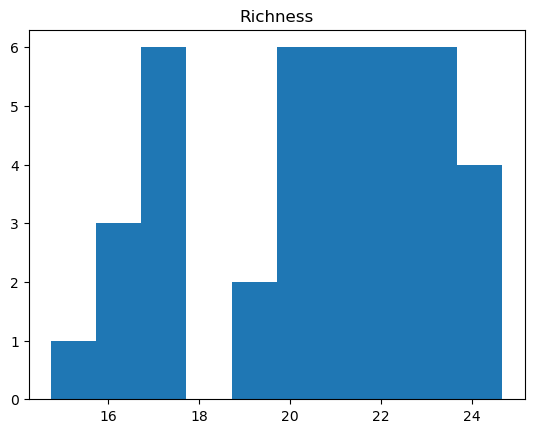

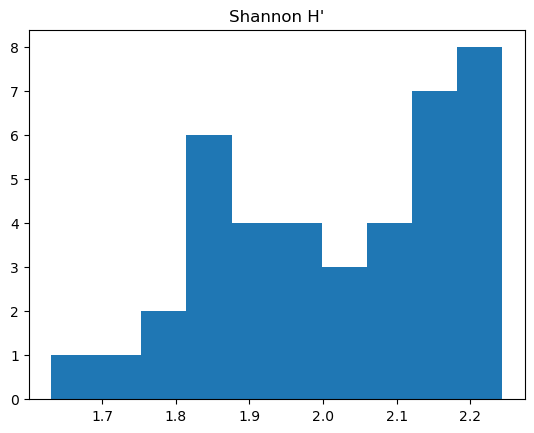

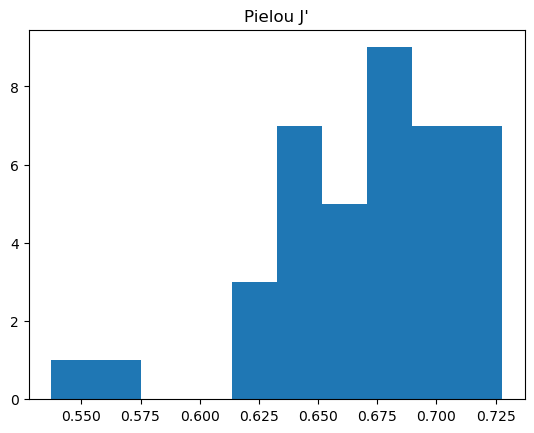

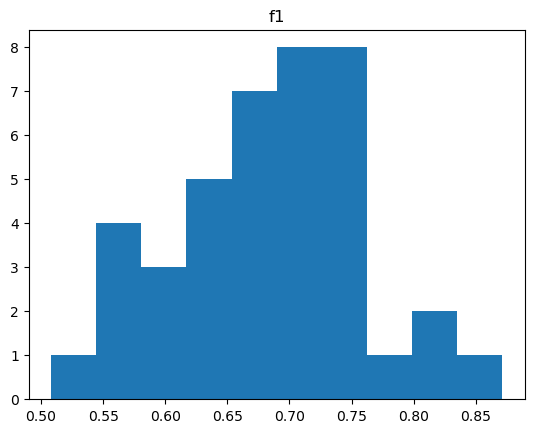

In [56]:
for col in list(final_feature_values.columns.values):
    plt.hist(final_feature_values[col])
    plt.title(col)
    plt.show()
    plt.close()

 slope: 0.0020280066542909705, intercept: 0.3675973170310748, p_value: 0.0004417303595202055, r_sq: 0.2804289804312525, std_err: 0.0005269907142365158


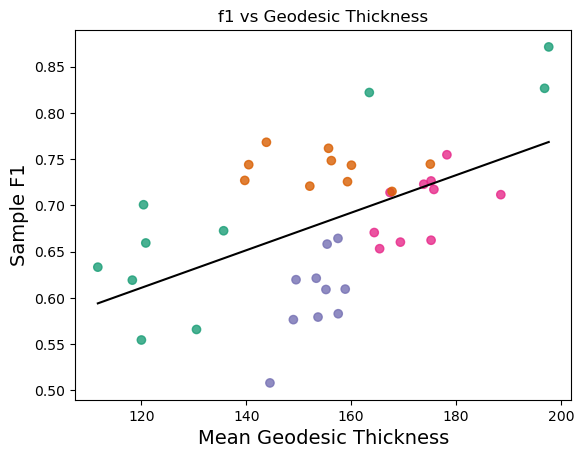

 slope: 0.7347727548121255, intercept: 0.4001726417421323, p_value: 3.351580918248973e-08, r_sq: 0.5561787210017679, std_err: 0.10647756770679145


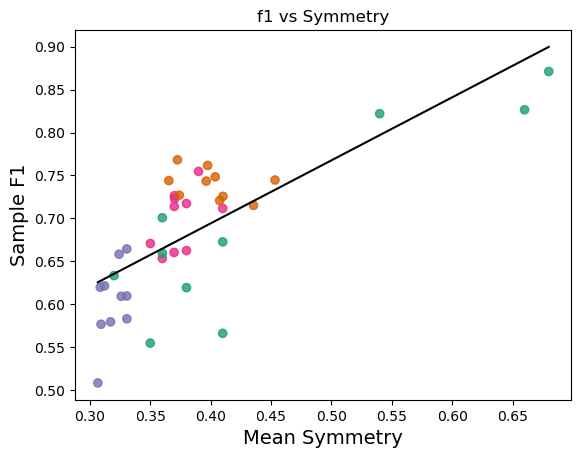

 slope: 0.020554707435474714, intercept: 0.2626212021921072, p_value: 6.667691815701761e-07, r_sq: 0.4823030336428952, std_err: 0.0034545963877822697


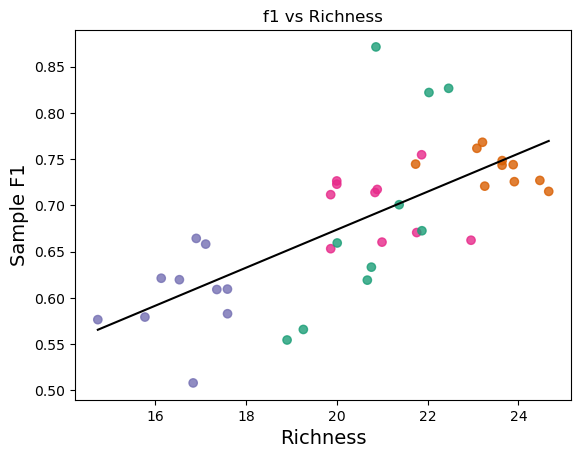

In [58]:
import matplotlib.lines as mlines
from scipy import stats
regionColors = {'Pacific': '#d95f02', 'Gulf':'#1b9e77', 'NL 2020': '#7570b3', 'NL 2021': '#e7298a'}
colors = []
for i, row in final_feature_df.iterrows():
    colors.append(regionColors[row['regionYear']])

for col in list(final_feature_df.columns.values):
    if col in ['f1', 'sample', 'regionYear']:
        continue
    if col not in ['Symmetry', 'Richness', 'Geodesic Thickness']:
        continue

    x = final_feature_df[col]
    y = final_feature_df['f1']
    # Calculate the line of best fit
    slope, intercept = np.polyfit(x, y, 1)  # Degree 1 for a linear fit
    x_ends = np.array([np.min(x), np.max(x)])
    line = slope * x_ends + intercept
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print(f" slope: {slope}, intercept: {intercept}, p_value: {p_value}, r_sq: {r_value**2}, std_err: {std_err}")
    plt.plot(x_ends, line, color='black', linestyle='-' if p_value < 0.05 else ':', label=f'Best Fit: y = {slope:.2f}x + {intercept:.2f}')



    
    plt.scatter(final_feature_df[col], final_feature_df['f1'], color=colors, alpha=0.8, label=list(final_feature_df['regionYear']))
    plt.title(f"f1 vs {col}")
    # Create custom legend handles with markers
    marker1 = mlines.Line2D([], [], color=regionColors['Gulf'], marker='o', markersize=8, linestyle='', label='Gulf')  # Custom circle marker for Series 1
    marker2 = mlines.Line2D([], [], color=regionColors['Pacific'], marker='o', markersize=8, linestyle='', label='Pacific')   # Custom square marker for Series 2
    marker3 = mlines.Line2D([], [], color=regionColors['NL 2020'], marker='o', markersize=8, linestyle='', label='NL 2020')  # Custom circle marker for Series 1
    marker4 = mlines.Line2D([], [], color=regionColors['NL 2021'], marker='o', markersize=8, linestyle='', label='NL 2021')   # Custom square marker for Series 2
    # Add the custom legend to the plot
    plt.ylabel('Sample F1', fontsize=14)
    plt.xlabel(f"{col}" if col == 'Richness' else f"Mean {col}", fontsize=14)
    # plt.legend(handles=[marker1, marker2, marker3, marker4])
    plt.show()
    plt.close()

In [149]:
final_feature_df['f1'].max()

0.8712383878322197

In [62]:
#RUN MULTIPLE REGRESSION WITH CHOSEN FEATURES

import statsmodels.api as sm
X = final_feature_df.drop(columns=['sample', 'regionYear', 'f1'])
X = X[['Richness', 'Symmetry', 'Geodesic Thickness',]].copy()
X = (X - X.min()) / (X.max() - X.min())
# Add a constant to the independent variables for the intercept term
X = sm.add_constant(X)
y = final_feature_df[['f1']]
# Fit the model
model = sm.OLS(y, X).fit()

# Get the summary of the model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                     f1   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     39.51
Date:                Fri, 21 Mar 2025   Prob (F-statistic):           1.77e-11
Time:                        11:08:34   Log-Likelihood:                 74.361
No. Observations:                  40   AIC:                            -140.7
Df Residuals:                      36   BIC:                            -134.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.5242      0